In [1]:
import argparse
import os
from scipy.io import loadmat
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import metrics
import math
from sklearn import metrics
from sklearn.metrics import r2_score  # ✅ 添加这行
import torch.nn.functional as F 

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
class Scaler():#对+数据进行标准化和缩放
    def __init__(self,data):  # data.shape (N,C,L)  or (N,C)
        self.data = data
        if self.data.ndim == 3: # (N,C,L)其中 N 是样本数，C 是特征数，L 表示数据的长度（如时间步长）。
            self.mean = self.data.mean(axis=(0,2), keepdims=True)#沿 axis=(0,2)（即样本维度和长度维度）计算均值、方差、最大值和最小值
            self.var = self.data.var(axis=(0,2), keepdims=True)#reshape(1, -1, 1) 将计算结果调整为合适的形状
            self.max = self.data.max(axis=(0,2), keepdims=True)
            self.min = self.data.min(axis=(0,2), keepdims=True)
        elif self.data.ndim == 2: # (N,C)
            self.mean = self.data.mean(axis=0, keepdims=True)
            self.var = self.data.var(axis=0, keepdims=True)#沿 axis=0（样本维度）
            self.max = self.data.max(axis=0, keepdims=True)
            self.min = self.data.min(axis=0, keepdims=True)
        else:
            raise ValueError('data dim error!')
        print(self.data.ndim)

    def standerd(self):#标准化方法
        X = (self.data - self.mean) / (self.var + 1e-6)
        return X

    def minmax(self,feature_range=(0,1)):#归一化方法
        if feature_range == (0,1):
            X = (self.data - self.min) / ((self.max - self.min) + 1e-6)
        elif feature_range == (-1,1):
            X = 2*(self.data - self.min) / ((self.max - self.min) + 1e-6)-1
        else:
            raise ValueError('feature_range error!')
        return X


In [4]:
class AverageMeter(object):#用于跟踪指标的实用工具，常用于深度学习模型的训练或评估过程中，帮助计算和维护例如损失或精度的平均值。
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):# 重置所有变量为初始状态
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):# 更新当前值、总和和计数器，计算新的平均值
        self.val = val
        self.sum += val * n 
        self.count += n
        self.avg = self.sum / self.count
        
def eval_metrix(true_label, pred_label):
    epsilon = 1e-8

    # 强制转换为 float64 类型
    true_label = np.array(true_label, dtype=np.float64).flatten()
    pred_label = np.array(pred_label, dtype=np.float64).flatten()

    # 异常值检查
    if np.any(np.isnan(true_label)) or np.any(np.isnan(pred_label)):
        raise ValueError("true_label or pred_label contains NaN.")
    if np.any(np.isinf(true_label)) or np.any(np.isinf(pred_label)):
        raise ValueError("true_label or pred_label contains Inf.")
    if np.any(np.abs(true_label) > 1e6) or np.any(np.abs(pred_label) > 1e6):
        raise ValueError("true_label or pred_label contains excessively large values.")

    # 计算指标
    MAE = metrics.mean_absolute_error(true_label, pred_label)
    MAPE = metrics.mean_absolute_percentage_error(true_label, pred_label)
    MSE = metrics.mean_squared_error(true_label, pred_label)
    RMSE = np.sqrt(MSE)
    RE = np.sum(np.abs(true_label - pred_label)) / np.sum(np.abs(true_label) + epsilon)
    R2 = r2_score(true_label, pred_label)

    return {'MAE': MAE, 'MAPE': MAPE, 'MSE': MSE, 'RMSE': RMSE, 'RE': RE, 'R2': R2}


        
def monotonic_loss(pred):
    """
    单调性惩罚损失：只惩罚预测值的上升趋势，鼓励 SOH 下降或平稳。
    输入 pred: Tensor, shape (B, T) 或 (B, 1)，假设时间在 dim=1 上。
    """
    if pred.dim() == 2 and pred.size(1) > 1:
        diff = pred[:, 1:] - pred[:, :-1]
        mono_penalty = torch.relu(diff)  # 上升部分的惩罚
        return mono_penalty.mean()
    else:
        return torch.tensor(0.0, device=pred.device, requires_grad=True)

def save_to_txt(save_name,string):
    f = open(save_name,mode='a')
    f.write(string)
    f.write('\n')
    f.close()


In [5]:
# class XJTUDdataset():
#     def __init__(self,args):
#         super().__init__()
#         self.root = 'C:/Users/86152/PycharmProjects/SOHbenchmark-main/data/XJTU'
#         self.max_capacity = 2.0
#         self.normalized_type = args.normalized_type
#         self.minmax_range = args.minmax_range
#         self.seed = args.random_seed
#         self.batch = args.batch
#         self.batch_size = args.batch_size


#     def _parser_mat_data(self,battery_i_mat):# 用于解析电池数据并返回特征和标签，标签为电池的健康状态（SOH）
#         '''
#         :param battery_i_mat: shape:(1,len)#特定电池的原始数据矩阵（形状为 (1, len)）
#         :return: np.array
#         '''
#         data = []#存放处理后的特征数据和容量标签
#         label = []
#         for i in range(battery_i_mat.shape[1]):#（循环次数等于数据的第二维长度）
#             cycle_i_data = battery_i_mat[0,i]
#             time = cycle_i_data['relative_time_min'] # (1,128)
#             current = cycle_i_data['current_A'] # (1,128)
#             voltage = cycle_i_data['voltage_V'] # (1,128)
#             temperature = cycle_i_data['temperature_C'] # (1,128)
#             capacity = cycle_i_data['capacity'][0]
#             label.append(capacity)
#             cycle_i = np.concatenate([time,current,voltage,temperature],axis=0)#形状为 (4, 128)
#             data.append(cycle_i)
#         data = np.array(data,dtype=np.float32)
#         label = np.array(label,dtype=np.float32)
#         print(data.shape,label.shape)

#         scaler = Scaler(data)
#         if self.normalized_type == 'standard':
#             data = scaler.standerd()
#         else:
#             data = scaler.minmax(feature_range=self.minmax_range)
#         soh = label / self.max_capacity#容量标签 label 除以电池最大容量 self.max_capacity 进行归一化。

#         return data,soh

#     def _encapsulation(self,train_x,train_y,test_x,test_y):
#         '''
#         Encapsulate the numpy.array into DataLoader
#         :param train_x: numpy.array
#         :param train_y: numpy.array
#         :param test_x: numpy.array
#         :param test_y: numpy.array
#         :return:
#         '''
#         train_x = torch.from_numpy(train_x)#转换成 PyTorch 的 DataLoader 格式，方便后续的模型训练、验证和测试
#         train_y = torch.from_numpy(train_y)
#         test_x = torch.from_numpy(test_x)
#         test_y = torch.from_numpy(test_y)

#         train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=self.seed)# 将训练数据 train_x 和 train_y 按 80% 的比例划分为训练集和验证集，验证集的比例为 20%。random_state=self.seed 确保分割的随机性可复现
#         train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=self.batch_size, shuffle=True,
#                                   drop_last=False)#shuffle=True 表示打乱数据，drop_last=False 表示保留最后一个批次，即使样本数量不足一个完整批次。
#         valid_loader = DataLoader(TensorDataset(valid_x, valid_y), batch_size=self.batch_size, shuffle=True,
#                                   drop_last=False)
#         test_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=self.batch_size, shuffle=False)#但 shuffle=False，保持测试数据的顺序。
#         return train_loader, valid_loader, test_loader

#     def _get_raw_data(self,path,test_battery_id):#接受参数 path（文件路径）和 test_battery_id（测试用电池 ID）。使用 loadmat 函数加载 .mat 文件数据，并将其存储在 mat 中。
#         mat = loadmat(path)
#         battery = mat['battery']
#         battery_ids = list(range(1, battery.shape[1] + 1))#从 1 到电池数量编号
#         if test_battery_id not in battery_ids:
#             raise IndexError(f'"test_battery" must be in the {battery_ids}, but got {test_battery_id}. ')

#         test_battery = battery[0, test_battery_id - 1][0]
#         print(f'test battery id: {test_battery_id}, test data shape: ', end='')
#         test_x, test_y = self._parser_mat_data(test_battery)
        
#         train_x, train_y = [], []
#         for id in battery_ids:
#             if id == test_battery_id:
#                 continue
#             print(f'train battery id: {id}, ', end='')
#             train_battery = battery[0, id - 1][0]
#             x, y = self._parser_mat_data(train_battery)
#             train_x.append(x)
#             train_y.append(y)
#         train_x = np.concatenate(train_x, axis=0)
#         train_y = np.concatenate(train_y, axis=0)
#         print('train data shape: ', train_x.shape, train_y.shape)#将 train_x 和 train_y 中的列表项按行连接成完整的训练数据矩阵和标签向量，并打印它们的形状。

#         return self._encapsulation(train_x, train_y, test_x, test_y)

#     def get_charge_data(self,test_battery_id=1):
#         print('----------- load charge data -------------')
#         file_name = f'batch-{self.batch}.mat'
#         self.charge_path = os.path.join(self.root, 'charge', file_name)#根据类的 batch 属性构建文件名（如 batch-1.mat），并将其与根目录 self.root 以及子文件夹 charge 组合成充电数据文件的完整路径 self.charge_path
#         train_loader, valid_loader, test_loader = self._get_raw_data(path=self.charge_path,test_battery_id=test_battery_id)
#         data_dict = {'train':train_loader,
#                      'test':test_loader,
#                      'valid':valid_loader}
#         print('-------------  finished !  ---------------')
#         return data_dict


#     def get_partial_data(self,test_battery_id=1):#加载特定电压范围内的部分充电数据
#         print('----------- load partial_charge data -------------')
#         file_name = f'batch-{self.batch}_3.7-4.1.mat'
#         if self.batch == 6:
#             file_name = f'batch-{self.batch}_3.9-4.19.mat'
#         self.partial_path = os.path.join(self.root, 'partial_charge', file_name)
#         train_loader, valid_loader, test_loader = self._get_raw_data(path=self.partial_path,
#                                                                      test_battery_id=test_battery_id)
#         data_dict = {'train': train_loader,
#                      'test': test_loader,
#                      'valid': valid_loader}
#         print('----------------  finished !  --------------------')
#         return data_dict

#     def _parser_xlsx(self,df_i):
#         '''
#         features dataframe
#         :param df_i: shape:(N,C+1)
#         :return:
#         '''
#         N = df_i.shape[0]
#         x = np.array(df_i.iloc[:, :-1],dtype=np.float32)
#         label = np.array(df_i['label'],dtype=np.float32).reshape(-1, 1)

#         scaler = Scaler(x)
#         if self.normalized_type == 'standard':
#             data = scaler.standerd()
#         else:
#             data = scaler.minmax(feature_range=self.minmax_range)
#         soh = label / self.max_capacity

#         return data, soh

#     def get_features(self,test_battery_id=1):#加载手工特征数据，并将数据组织为训练、验证和测试集。
#         print('----------- load features -------------')
#         file_name = f'batch-{self.batch}_features.xlsx'
#         self.features_path = os.path.join(self.root, 'handcraft_features', file_name)
#         df = pd.read_excel(self.features_path,sheet_name=None)
#         sheet_names = list(df.keys())
#         battery_ids = list(range(1, len(sheet_names)+1))

#         if test_battery_id not in battery_ids:
#             raise IndexError(f'"test_battery" must be in the {battery_ids}, but got {test_battery_id}. ')
#         test_battery_df = pd.read_excel(self.features_path,sheet_name=test_battery_id-1,header=0)
#         test_x,test_y = self._parser_xlsx(test_battery_df)
#         print(f'test battery id: {test_battery_id}, test data shape: {test_x.shape}, {test_y.shape}')

#         train_x, train_y = [], []
        
#         for id in battery_ids:
#             if id == test_battery_id:
#                 continue
#             sheet_name = sheet_names[id-1]
#             df_i = df[sheet_name]
#             x, y = self._parser_xlsx(df_i)
#             print(f'train battery id: {id}, {x.shape}, {y.shape}')
#             train_x.append(x)
#             train_y.append(y)
#         train_x = np.concatenate(train_x,axis=0)
#         train_y = np.concatenate(train_y,axis=0)
#         print('train data shape: ', train_x.shape, train_y.shape)

#         train_loader, valid_loader, test_loader = self._encapsulation(train_x, train_y, test_x, test_y)
#         data_dict = {'train': train_loader,
#                      'test': test_loader,
#                      'valid': valid_loader}
#         print('---------------  finished !  ----------------')
#         return data_dict




In [6]:
# if __name__ == '__main__':
#     import argparse
#     def get_args():

#         parser = argparse.ArgumentParser(description='dataloader test')
#         parser.add_argument('--random_seed',type=int,default=2023)
#         # data
#         parser.add_argument('--data', type=str, default='XJTU', choices=['XJTU', 'MIT', 'CALCE'])
#         parser.add_argument('--input_type', type=str, default='charge',
#                             choices=['charge', 'partial_charge', 'handcraft_features'])
#         parser.add_argument('--normalized_type', type=str, default='minmax', choices=['minmax', 'standard'])
#         parser.add_argument('--minmax_range', type=tuple, default=(0, 1), choices=[(0, 1), (1, 1)])
#         parser.add_argument('--batch_size', type=int, default=128)
#         # the parameters for XJTU data
#         parser.add_argument('--batch', type=int, default=1, choices=[1, 2, 3, 4, 5])

#         # Use parse_known_args to ignore unrecognized arguments
#         args, unknown = parser.parse_known_args()
#         return args

#     args = get_args()
#     data = XJTUDdataset(args)
#     charge_data = data.get_charge_data()
#     partial_data = data.get_partial_data()
#     features = data.get_features()


In [7]:
class MITDdataset():
    def __init__(self,args):
        super(MITDdataset).__init__()
        self.root = 'D:/pythonproject/SOHbenchmark-main/data/MIT'
        self.max_capacity = 1.1
        self.normalized_type = args.normalized_type
        self.minmax_range = args.minmax_range
        self.seed = args.random_seed
        self.batch = args.batch
        self.batch_size = args.batch_size
        if args.batch < 1 or args.batch > 9:
            raise IndexError(f'"batch" must be in the [1, 9], but got {self.batch}. ')


    def _parser_mat_data(self,battery_i_mat):
        '''
        :param battery_i_mat: shape:(1,len)
        :return: np.array
        '''
        data = []
        label = []
        for i in range(battery_i_mat.shape[1]):
            cycle_i_data = battery_i_mat[0,i]
            time = cycle_i_data['relative_time_min'] # (1,128)
            current = cycle_i_data['current_A'] # (1,128)
            voltage = cycle_i_data['voltage_V'] # (1,128)
            temperature = cycle_i_data['temperature_C'] # (1,128)
            capacity = cycle_i_data['capacity'][0]
            label.append(capacity)
            cycle_i = np.concatenate([time,current,voltage,temperature],axis=0)
            data.append(cycle_i)
        data = np.array(data,dtype=np.float32)
        label = np.array(label,dtype=np.float32)
        print(data.shape,label.shape)

        scaler = Scaler(data)
        if self.normalized_type == 'standard':
            data = scaler.standerd()
        else:
            data = scaler.minmax(feature_range=self.minmax_range)
        soh = label / self.max_capacity

        return data,soh

    def _encapsulation(self,train_x,train_y,test_x,test_y):
        '''
        Encapsulate the numpy.array into DataLoader
        :param train_x: numpy.array
        :param train_y: numpy.array
        :param test_x: numpy.array
        :param test_y: numpy.array
        :return:
        '''
        train_x = torch.from_numpy(train_x)
        train_y = torch.from_numpy(train_y)
        test_x = torch.from_numpy(test_x)
        test_y = torch.from_numpy(test_y)

        train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=self.seed)
        train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=self.batch_size, shuffle=True,
                                  drop_last=False)
        valid_loader = DataLoader(TensorDataset(valid_x, valid_y), batch_size=self.batch_size, shuffle=True,
                                  drop_last=False)
        test_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=self.batch_size, shuffle=False)
        return train_loader, valid_loader, test_loader

    def _get_raw_data(self,path,test_battery_id):
        mat = loadmat(path)
        battery = mat['battery']
        battery_ids = list(range(1, battery.shape[1] + 1))
        if test_battery_id not in battery_ids:
            raise IndexError(f'"test_battery" must be in the {battery_ids}, but got {test_battery_id}. ')

        test_battery = battery[0, test_battery_id - 1][0]
        print(f'test battery id: {test_battery_id}, test data shape: ', end='')
        test_x, test_y = self._parser_mat_data(test_battery)
        train_x, train_y = [], []
        for id in battery_ids:
            if id == test_battery_id:
                continue
            print(f'train battery id: {id}, ', end='')
            train_battery = battery[0, id - 1][0]
            x, y = self._parser_mat_data(train_battery)
            train_x.append(x)
            train_y.append(y)
        train_x = np.concatenate(train_x, axis=0)
        train_y = np.concatenate(train_y, axis=0)
        print('train data shape: ', train_x.shape, train_y.shape)

        return self._encapsulation(train_x, train_y, test_x, test_y)

    def get_charge_data(self,test_battery_id=1):
        print('----------- load charge data -------------')
        charge_files = os.listdir(os.path.join(self.root, 'charge'))
        file_name = charge_files[self.batch-1]

        self.charge_path = os.path.join(self.root, 'charge', file_name)
        train_loader, valid_loader, test_loader = self._get_raw_data(path=self.charge_path,test_battery_id=test_battery_id)
        data_dict = {'train':train_loader,
                     'test':test_loader,
                     'valid':valid_loader}
        print('-------------  finished !  ---------------')
        return data_dict


    def get_partial_data(self,test_battery_id=1):
        print('----------- load partial_charge data -------------')
        charge_files = os.listdir(os.path.join(self.root, 'partial_charge'))
        file_name = charge_files[self.batch - 1]
        self.partial_path = os.path.join(self.root, 'partial_charge', file_name)
        train_loader, valid_loader, test_loader = self._get_raw_data(path=self.partial_path,
                                                                     test_battery_id=test_battery_id)
        data_dict = {'train': train_loader,
                     'test': test_loader,
                     'valid': valid_loader}
        print('----------------  finished !  --------------------')
        return data_dict

    def _parser_xlsx(self,df_i):
        '''
        features dataframe
        :param df_i: shape:(N,C+1)
        :return:
        '''
        N = df_i.shape[0]
        x = np.array(df_i.iloc[:, :-1],dtype=np.float32)
        label = np.array(df_i['label'],dtype=np.float32).reshape(-1, 1)

        scaler = Scaler(x)
        if self.normalized_type == 'standard':
            data = scaler.standerd()
        else:
            data = scaler.minmax(feature_range=self.minmax_range)
        soh = label / self.max_capacity

        return data, soh

    def get_features(self,test_battery_id=1):
        print('----------- load features -------------')
        charge_files = os.listdir(os.path.join(self.root, 'handcraft_features'))
        file_name = charge_files[self.batch - 1]
        self.features_path = os.path.join(self.root, 'handcraft_features', file_name)
        df = pd.read_excel(self.features_path,sheet_name=None)
        sheet_names = list(df.keys())
        battery_ids = list(range(1, len(sheet_names)+1))

        if test_battery_id not in battery_ids:
            raise IndexError(f'"test_battery" must be in the {battery_ids}, but got {test_battery_id}. ')
        test_battery_df = pd.read_excel(self.features_path,sheet_name=test_battery_id-1,header=0)
        test_x,test_y = self._parser_xlsx(test_battery_df)
        print(f'test battery id: {test_battery_id}, test data shape: {test_x.shape}, {test_y.shape}')

        train_x, train_y = [], []
        for id in battery_ids:
            if id == test_battery_id:
                continue
            sheet_name = sheet_names[id-1]
            df_i = df[sheet_name]
            x, y = self._parser_xlsx(df_i)
            print(f'train battery id: {id}, {x.shape}, {y.shape}')
            train_x.append(x)
            train_y.append(y)
        train_x = np.concatenate(train_x,axis=0)
        train_y = np.concatenate(train_y,axis=0)
        print('train data shape: ', train_x.shape, train_y.shape)

        train_loader, valid_loader, test_loader = self._encapsulation(train_x, train_y, test_x, test_y)
        data_dict = {'train': train_loader,
                     'test': test_loader,
                     'valid': valid_loader}
        print('---------------  finished !  ----------------')
        return data_dict






In [8]:
if __name__ == '__main__':
    import argparse
    def get_args():

        parser = argparse.ArgumentParser(description='dataloader test')
        parser.add_argument('--random_seed',type=int,default=2023)
        # data
        parser.add_argument('--data', type=str, default='MIT', choices=['XJTU', 'MIT'])
        parser.add_argument('--input_type', type=str, default='charge', choices=['charge', 'partial_charge', 'handcraft_features'])
        parser.add_argument('--normalized_type', type=str, default='minmax', choices=['minmax', 'standard'])
        parser.add_argument('--minmax_range', type=tuple, default=(-1, 1), choices=[(0, 1), (-1, 1)])
        parser.add_argument('--batch_size', type=int, default=128)
        # the parameters for XJTU data
        parser.add_argument('--batch', type=int, default=2, choices=[1, 2, 3, 4, 5])

        args, unknown = parser.parse_known_args()
        return args


    args = get_args()
    data = MITDdataset(args)
    charge_data = data.get_charge_data(test_battery_id=3)
    partial_charge = data.get_partial_data(test_battery_id=5)
    features = data.get_features(test_battery_id=2)
    



----------- load charge data -------------
test battery id: 3, test data shape: (989, 4, 128) (989, 1)
3
train battery id: 1, (914, 4, 128) (914, 1)
3
train battery id: 2, (678, 4, 128) (678, 1)
3
train battery id: 4, (1089, 4, 128) (1089, 1)
3
train battery id: 5, (751, 4, 128) (751, 1)
3
train data shape:  (3432, 4, 128) (3432, 1)
-------------  finished !  ---------------
----------- load partial_charge data -------------
test battery id: 5, test data shape: (751, 4, 128) (751, 1)
3
train battery id: 1, (914, 4, 128) (914, 1)
3
train battery id: 2, (678, 4, 128) (678, 1)
3
train battery id: 3, (989, 4, 128) (989, 1)
3
train battery id: 4, (1089, 4, 128) (1089, 1)
3
train data shape:  (3670, 4, 128) (3670, 1)
----------------  finished !  --------------------
----------- load features -------------
2
test battery id: 2, test data shape: (678, 67), (678, 1)
2
train battery id: 1, (914, 67), (914, 1)
2
train battery id: 3, (989, 67), (989, 1)
2
train battery id: 4, (1089, 67), (1089, 1

In [9]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

print(torch.cuda.is_available())

False


In [10]:
# class ResBlock(nn.Module):#ResBlock 是一个残差模块，通常用于深度神经网络中，通过在卷积路径之外添加“跳跃连接”或“残差连接”来帮助信号从输入直接传递到输出。这种结构可以有效地缓解梯度消失问题，提升深层网络的训练效果

#     def __init__(self, input_channel, output_channel, stride):
#         super(ResBlock, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv1d(input_channel, output_channel, kernel_size=3, stride=stride, padding=1),
#             nn.BatchNorm1d(output_channel),
#             nn.ReLU(),

#             nn.Conv1d(output_channel, output_channel, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm1d(output_channel)
#         )

#         self.skip_connection = nn.Sequential()
#         if output_channel != input_channel:#如果输入通道和输出通道不相等，或步幅不为1，跳跃连接包含一个调整通道数的卷积层和一个批量归一化层，以使维度匹配。
#             self.skip_connection = nn.Sequential(
#                 nn.Conv1d(input_channel, output_channel, kernel_size=1, stride=stride),
#                 nn.BatchNorm1d(output_channel)
#             )

#         self.relu = nn.ReLU()

#     def forward(self, x):#前向传播过程
#         out = self.conv(x)#输入 x 先通过卷积路径 self.conv。
#         out = self.skip_connection(x) + out#输入 x 通过跳跃连接，与卷积路径的输出相加。
#         out = self.relu(out)#相加后的结果通过 ReLU 激活函数输出，得到模块的输出。
#         return out



# class CNN(nn.Module):
#     '''
#     input shape: (N,4,128)
#     '''
#     def __init__(self):
#         super(CNN,self).__init__()#旨在处理输入形状为 (N, 4, 128) 的数据，其中 N 是批量大小，4 是通道数，128 是每个通道的长度。
#         self.layer1 = ResBlock(input_channel=4, output_channel=16, stride=1) # N,16,128
#         self.layer2 = ResBlock(input_channel=16, output_channel=32, stride=2) # N,32,64
#         self.layer3 = ResBlock(input_channel=32, output_channel=64, stride=2)  # N,64,32
#         self.layer4 = ResBlock(input_channel=64, output_channel=96, stride=2)  # N,96,16
#         self.layer5 = ResBlock(input_channel=96, output_channel=128, stride=2)  # N,128,8

#         self.predictor = nn.Sequential(
#             nn.Linear(128 * 8, 128),#预测器将卷积层的输出展平，输入维度为 128 * 8 = 1024， 使用一个全连接层将其映射到大小为 128 的隐藏层
#             nn.ReLU(),#用 ReLU 激活，最终映射到输出维度 1
#             nn.Linear(128, 1)#输出 pred 为标量预测结果（形状为 (N, 1)），适用于回归任务。

#         )


#     def forward(self,x):
#         '''
#         :param x: shape:(N,4,128)
#         :return:
#         '''
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         pred = self.predictor(out.view(out.size(0), -1))#在最后一个卷积层输出后，将数据展平，并通过 predictor 进行回归预测。
#         return pred#输出 pred：为形状 (N, 1) 的张量，通常用作回归输出。

# if __name__ == '__main__':
#     x = torch.rand(30,4,128)#生成了一个形状为 (30, 4, 128) 的随机张量，表示一个批量大小为30的输入数据，每个样本有4个通道、128个时间步或特征

#     net = CNN()
#     y = net(x)
#     print(x.shape,y.shape)#输入形状：x.shape 应为 (30, 4, 128)。输出形状：根据模型设计，y.shape 应为 (30, 1)，即批量大小为30的标量预测。

#     num_params = sum(param.numel() for param in net.parameters())#计算 CNN 模型的总参数量，并打印。
#     print(num_params)

In [11]:
# class LSTM(nn.Module):
#     '''
#     input shape: (N,4,128)
#     '''

#     def __init__(self):
#         super(LSTM, self).__init__()
#         self.net = nn.LSTM(input_size=4,hidden_size=128,num_layers=2,batch_first=True)
#         self.predictor = nn.Sequential(
#             nn.Linear(128,64),
#             nn.LeakyReLU(),
#             nn.Linear(64,1)
#         )

#     def forward(self, x):
#         '''
#         :param x: (N,4,128)
#         :return:
#         '''
#         x = x.transpose(1, 2)
#         embed,(_,_) = self.net(x)
#         out = embed[:,-1,:]
#         pred = self.predictor(out)

#         return pred

# if __name__ == '__main__':
#     x = torch.rand(30,4,128)

#     net = LSTM()
#     y = net(x)
#     print(x.shape,y.shape)

#     num_params = sum(param.numel() for param in net.parameters())
#     print(num_params)

In [12]:
# class MLP(nn.Module):
#     '''
#     input shape: (N,4,128)
#     '''

#     def __init__(self):
#         super(MLP, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(128*4,256),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(256,128),
#             nn.ReLU(),
#         )
#         self.predictor = nn.Sequential(
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 1)
#         )

#     def forward(self, x):
#         '''
#         :param x: (N,4,128)
#         :return:
#         '''
#         x = x.view(-1,4*128)
#         fea = self.net(x)
#         out = self.predictor(fea)
#         return out

# if __name__ == '__main__':
#     x = torch.rand(30,4,128)

#     net = MLP()
#     y = net(x)
#     print(x.shape,y.shape)

#     num_params = sum(param.numel() for param in net.parameters())
#     print(num_params)

In [13]:
input =5
numf = 64
dim = 64
emb_dropout = 0.25
input_size=4    # 输入通道
hidden_size=64  # 隐藏层
output_size=1
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):  # x: [B, C, L]
        x = x.permute(0, 2, 1)  # [B, L, C] 适配 GRU
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 取最后一个时间步
        return out


In [14]:
class SOHMode(nn.Module):
    '''
    data shape:
    charge_data (N,4,128)
    partial_data (N,4,128)
    features (N,1,67)
    '''
    #args (Namespace): 配置参数，包括设备（device）、学习率（lr）和权重衰减（weight_decay）等。
    def __init__(self,args):
        super(SOHMode,self).__init__()
        self.args = args  # 保存配置参数
        self.pre_net = self._preprocessing_net()  # 预处理网络，用于特征提取或预处理
        self.backbone = self._backbone()  # 主干网络，用于模型的主要预测逻辑
        self.pre_net.to(args.device)  # 将预处理网络放到指定设备
        self.backbone.to(args.device)  # 将主干网络放到指定设备
        # 初始化模型权重
        self._initialize_weights()
        
        # 优化器
        self.optimizer = torch.optim.Adam(self.parameters(),lr=self.args.lr, weight_decay=self.args.weight_decay)

        # 学习率调度器
        #self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer,milestones=[30, 70], gamma=0.5 )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=10, factor=0.5)
       # 损失函数
       #self.mse = torch.nn.MSELoss()
        self.criterion = torch.nn.SmoothL1Loss()  # 替换 MSELoss 更鲁棒
        self.lambda_mono = 0.5

        # 存储损失的平均值
        self.loss_meter = AverageMeter()
        # 损失分项记录
        self.loss_smoothl1_list = []
        self.loss_monotonic_list = []

        # 存储最佳状态
        self.best_state = None
        
        # ======== 标签归一化参数（建议） ========
        self.label_mean = args.label_mean if hasattr(args, 'label_mean') else 0.8
        self.label_std = args.label_std if hasattr(args, 'label_std') else 0.1

    def _preprocessing_net(self):
        '''
        A preprocess network which transform data from different sources into the same shape
        :return: A network, with output shape (N,4,128)
        '''
        if self.args.input_type == 'charge': # charge_data (N,4,128)
            net = nn.Conv1d(in_channels=4,out_channels=4,kernel_size=1)
        elif self.args.input_type == 'partial_charge': #partial_data (N,4,128)
            net = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1)
        else:  # features (N,1,67)
            net = nn.Linear(67,128*4) #(N,128*4)

        return net


    def _backbone(self):
        if self.args.model == 'GRUModel':
            backbone = GRUModel(
                input_size=self.args.input_size,
                hidden_size=self.args.hidden_size,
                output_size=self.args.output_size
            )
        else:
            raise ValueError(f"Unsupported model: {self.args.model}")
        return backbone

    def forward(self,x):#前向传播函数，根据输入类型调用预处理网络并将其输入到主干网络中。
        if self.args.input_type == 'handcraft_features':  # 仅在特征输入时应用预处理
            x = self.pre_net(x)  # 使用全连接层将特征转换
            x = x.view(-1, 4, 128)  # 重塑张量形状
        out = self.backbone(x)  # 使用主干网络进行预测
        return out

    def _train_one_epoch(self, train_loader, e):
        # 将预处理网络和主干网络设为训练模式
        self.pre_net.train()
        self.backbone.train()

        # 重置损失监测器
        self.loss_meter.reset()

        # 遍历训练数据
        for data, label in train_loader:
            # 将数据和标签加载到指定设备上
            data, label = data.to(self.args.device), label.to(self.args.device)
        
            # 标签归一化（训练阶段）
            label_norm = (label - self.label_mean) / self.label_std
           
            pred = self.forward(data)
            
            loss_main = self.criterion(pred, label_norm)
            loss_mono = monotonic_loss(pred)  # ← 无论如何都先定义

            if e <= 5:
                loss = loss_main  # 前几轮不要加入单调性
            else:
                loss = loss_main + self.lambda_mono * loss_mono

            # 梯度清零、反向传播并更新参数
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)  # 防止梯度爆炸
            self.optimizer.step()
  
            # 更新损失监测器
            self.loss_meter.update(loss.item())
            self.loss_smoothl1_list.append(loss_main.item())
            self.loss_monotonic_list.append(loss_mono.item())


    def predict(self,test_loader):
        # 将预处理网络和主干网络设为评估模式
        self.pre_net.eval()
        self.backbone.eval()
        self.loss_meter.reset()
        
        # 重置损失监测器 
        true_label = []
        pred_label = []
        
        # 禁用梯度计算，以提高推理效率
        with torch.no_grad():
            # 遍历测试数据
            for data, label in test_loader:
                 # 将数据和标签加载到指定设备上
                data, label = data.to(self.args.device), label.to(self.args.device)
                # 前向传播，获取预测结果
                pred = self.forward(data)
                
                 # 反归一化预测值
                pred = pred * self.label_std + self.label_mean
                
                loss = self.criterion((pred - self.label_mean) / self.label_std, (label - self.label_mean) / self.label_std)

                # 更新损失监测器
                self.loss_meter.update(loss.item())
                # 转换为 NumPy 并 flatten，避免嵌套列表结构
                true_label.append(label.cpu().numpy().astype(np.float64).reshape(-1))
                pred_label.append(pred.cpu().numpy().astype(np.float64).reshape(-1))

            # 拼接为完整数组
        self.true_label = np.concatenate(true_label)
        self.pred_label = np.concatenate(pred_label)

        return self.true_label, self.pred_label

    def Train(self,train_loader,valid_loader,test_loader,save_folder=None):
        min_loss = 10 #记录验证集的最低损失，初始值设为10。
        stop = 0 #记录早停计数器，如果训练损失未改善超过一定轮数，则停止训练。
        self.train_loss = []#列表分别存储每个 epoch 的训练和验证损失
        self.valid_loss = []#用于保存测试集的真实和预测标签
        
        # 新增指标保存列表
        self.valid_MAE = []
        self.valid_MAPE = []
        self.valid_R2 = []
    
        
        self.test_loss = []
        self.true_label, self.pred_label = None, None
        
        
        self.best_MAE = float('inf')
        self.best_MAPE = float('inf')
        self.best_R2 = -float('inf')
        
        print("valid size:", len(valid_loader.dataset))



        for e in range(1,self.args.n_epoch+1):
            self._train_one_epoch(train_loader, e)
            train_l = self.loss_meter.avg
            self.train_loss.append(train_l)
            
            stop += 1
            #计算验证集的预测和损失
            self.predict(valid_loader)
            valid_l = self.loss_meter.avg
            self.valid_loss.append(valid_l)
            self.scheduler.step(valid_l)#更新学习率
            # 计算额外指标
            errors = eval_metrix(self.true_label, self.pred_label)
            self.valid_MAE.append(errors['MAE'])
            self.valid_MAPE.append(errors['MAPE'])
            self.valid_R2.append(errors['R2'])
            
            #从优化器中提取学习率并打印训练信息（当前 epoch、训练损失、验证损失和学习率）
            lr = self.optimizer.state_dict()['param_groups'][0]['lr']
            
            print(f"epoch=[{e}/{self.args.n_epoch}]  train loss : {train_l:.7f}  valid loss : {valid_l:.7f}  lr : {lr:.7f}")
            
            if e % 10 == 0:
                print("")

            #如果当前验证损失 valid_l 低于 min_loss，保存当前模型状态（pre_net 和 backbone）并计算测试集的预测损失。
            if valid_l < min_loss:
                self.best_state = {'pre_net': self.pre_net.state_dict(),
                                   'backbone': self.backbone.state_dict()}
                self.true_label, self.pred_label = self.predict(test_loader)
                errors = eval_metrix(self.true_label, self.pred_label)

                # 保存最佳指标（★）
                if errors['MAE'] < self.best_MAE:
                    self.best_MAE = errors['MAE']
                if errors['MAPE'] < self.best_MAPE:
                    self.best_MAPE = errors['MAPE']
                if errors['R2'] > self.best_R2:
                    self.best_R2 = errors['R2']


                print(f' ------ test loss : {self.loss_meter.avg:.7f}')
                for k, v in errors.items():
                    print(f"{k} : {v:.7f}")

                min_loss = valid_l
                stop = 0
           
        if save_folder is not None:
            self.save_all(save_folder)#调用 save_all(save_folder) 保存模型和训练结果。
             # Plot the loss after training
            self._plot_loss(self.train_loss, self.valid_loss)
            true_label, pred_label = self.predict(test_loader)
            
            self._plot_metrics(self.valid_MAE, self.valid_MAPE, self.valid_R2)
            self.plot_soh_predictions(self.true_label, self.pred_label)
            self.plot_soh_predictions(self.true_label, self.pred_label)
            


    def save_all(self,folder):#保存模型的训练结果和最佳模型的状态
        if not os.path.exists(folder):#如果指定的 folder 路径不存在，则创建该文件夹以存储模型数据和结果。
            os.makedirs(folder)

        prefix = self.args.model + '_' + self.args.input_type#以模型名称和输入类型为前缀，方便文件区分
        errors = eval_metrix(self.true_label,self.pred_label)#利用 eval_metrix 函数将真实标签和预测标签进行比较得到误差
        np.savez(os.path.join(folder, f'{prefix}_results.npz'),
            train_loss=np.array(self.train_loss),
            valid_loss=np.array(self.valid_loss),
            valid_MAE=np.array(self.valid_MAE),
            valid_MAPE=np.array(self.valid_MAPE),
            valid_R2=np.array(self.valid_R2),
            true_label=np.array(self.true_label),
            pred_label=np.array(self.pred_label),
            test_errors=np.array(errors),
            best_MAE=np.array(self.best_MAE),
            best_MAPE=np.array(self.best_MAPE),
            best_R2=np.array(self.best_R2),

            loss_smoothl1=np.array(self.loss_smoothl1_list),
            loss_monotonic=np.array(self.loss_monotonic_list),
            lambda_mono=np.array(self.lambda_mono)
        )
        torch.save(self.best_state, os.path.join(folder, f'{prefix}_model.pkl'))

    def _plot_loss(self,train_loss,valid_loss):#绘制训练和验证集的损失变化趋势

        self.fig_loss = plt.figure()
        plt.plot(train_loss,label='train')
        plt.plot(valid_loss,label='valid')
        plt.xlabel('epoch')
        plt.ylabel('MSE')
        plt.legend()#显示训练损失（train）和验证损失（valid）的标签，方便辨识
        plt.show()
        plt.close()
        
    def _plot_metrics(self, MAE_list, MAPE_list, R2_list):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(MAE_list, label='MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.title('Validation MAE')
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.plot(MAPE_list, label='MAPE')
        plt.xlabel('Epoch')
        plt.ylabel('MAPE (%)')
        plt.title('Validation MAPE')
        plt.grid()

        plt.subplot(1, 3, 3)
        plt.plot(R2_list, label='R2 Score')
        plt.xlabel('Epoch')
        plt.ylabel('R2')
        plt.title('Validation R2 Score')
        plt.grid()

        plt.tight_layout()
        plt.show()

        
    def plot_soh_predictions(self,true_label, pred_label):
        plt.figure(figsize=(10, 6))
        plt.plot(true_label, label='True SOH', color='blue', linewidth=2)
        plt.plot(pred_label, label='Predicted SOH', color='orange', linestyle='--', linewidth=2)
        
        plt.title('True vs Predicted SOH Values')
        plt.xlabel('Samples')
        plt.ylabel('SOH Value')
        plt.legend()
        plt.grid()
        plt.show()
    
    def _initialize_weights(self):#用于为模型的各层权重进行初始化。权重初始化是深度学习模型训练中非常重要的一步，能够帮助模型更好、更快地收敛。
        for m in self.modules():#通过 self.modules() 遍历模型的所有子模块（层），根据每个子模块的类型来选择合适的初始化方式。
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')#使用 kaiming_normal_ 进行权重初始化，这是一种适合ReLU激活函数的初始化方法，有助于防止梯度消失或爆炸。
                if m.bias is not None:#如果卷积层有偏置（bias），则将其初始化为 0。
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)#将批归一化层的权重 weight 初始化为1，保持其默认缩放。
                nn.init.constant_(m.bias, 0)#将偏置 bias 初始化为0，确保批归一化层的均值偏置初始为零偏移。
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)#使用 nn.init.normal_ 方法将线性层的权重 weight 初始化为均值为0、标准差为0.01的正态分布。
                nn.init.constant_(m.bias, 0)#将偏置 bias 初始化为0，以确保线性层的初始输出没有偏移。

In [15]:
if __name__ == '__main__':
    def get_args():
        import argparse
        parser = argparse.ArgumentParser(description='A benchmark for SOH estimation')
        parser.add_argument('--random_seed', type=int, default=2023)
        # data
        parser.add_argument('--data', type=str, default='MIT', choices=['XJTU', 'MIT'])
        parser.add_argument('--input_type', type=str, default='charge',
                            choices=['charge', 'partial_charge', 'handcraft_features'])
        parser.add_argument('--batch_size', type=int, default=128)
        parser.add_argument('--normalized_type', type=str, default='minmax', choices=['minmax', 'standard'])
        parser.add_argument('--minmax_range', type=tuple, default=(-1, 1), choices=[(0, 1), (-1, 1)])
        parser.add_argument('--batch', type=int, default=9, choices=[1, 2, 3, 4, 5, 6, 7, 8, 9])

        # model
        parser.add_argument('--model', type=str, default='GRUModel', choices=['GRUModel', 'TransCNN','CNN', 'LSTM', 'GRU', 'MLP', 'Attention'])

        parser.add_argument('--lr', type=float, default=2e-3)
        parser.add_argument('--weight_decay', default=5e-4)
        parser.add_argument('--n_epoch', type=int, default=150)
        parser.add_argument('--early_stop', default=20)
        parser.add_argument('--device', default='cpu')
        parser.add_argument('--input_size', type=int, default=4)     # 输入通道
        parser.add_argument('--hidden_size', type=int, default=64)   # 隐藏层
        parser.add_argument('--output_size', type=int, default=1)    # 输出 SOH 回归

        # Use parse_known_args to ignore unrecognized arguments
        args, unknown = parser.parse_known_args()
        args.label_mean = 0.8
        args.label_std = 0.1
        return args


    args = get_args()
    model = SOHMode(args)
    #用于模型的随机输入张量，模拟实际的电池数据输入
    x1 = torch.rand(30,4,128).to('cpu') #形状为 (30, 4, 128) 的张量，表示批次大小为 30，每个样本有 4 个特征通道，特征长度为 128。
    x2 = torch.rand(30,1,67) #形状为 (30, 1, 67) 的张量，用于可能的附加特征。

    y = model(x1)
    print(model)
    print('output shape:',y.shape)

SOHMode(
  (pre_net): Conv1d(4, 4, kernel_size=(1,), stride=(1,))
  (backbone): GRUModel(
    (gru): GRU(4, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=1, bias=True)
  )
  (criterion): SmoothL1Loss()
)
output shape: torch.Size([30, 1])



[CrossVal] Batch=1, Fold=1, Model=GRUModel, Input=charge, Norm=minmax, Exp=1
----------- load charge data -------------
test battery id: 1, test data shape: (761, 4, 128) (761, 1)
3
train battery id: 2, (743, 4, 128) (743, 1)
3
train battery id: 3, (907, 4, 128) (907, 1)
3
train battery id: 4, (748, 4, 128) (748, 1)
3
train battery id: 5, (616, 4, 128) (616, 1)
3
train data shape:  (3014, 4, 128) (3014, 1)
-------------  finished !  ---------------
valid size: 603
epoch=[1/100]  train loss : 0.4387458  valid loss : 0.1219683  lr : 0.0020000
 ------ test loss : 0.1758975
MAE : 0.0463004
MAPE : 0.0524196
MSE : 0.0035445
RMSE : 0.0595356
RE : 0.0505041
R2 : -1.3726227
epoch=[2/100]  train loss : 0.0786682  valid loss : 0.0591354  lr : 0.0020000
 ------ test loss : 0.0832128
MAE : 0.0275639
MAPE : 0.0314657
MSE : 0.0016217
RMSE : 0.0402702
RE : 0.0300665
R2 : -0.0855356
epoch=[3/100]  train loss : 0.0600194  valid loss : 0.0574571  lr : 0.0020000
 ------ test loss : 0.0698420
MAE : 0.0277

epoch=[61/100]  train loss : 0.0016719  valid loss : 0.0011540  lr : 0.0020000
epoch=[62/100]  train loss : 0.0012357  valid loss : 0.0009465  lr : 0.0020000
 ------ test loss : 0.0047018
MAE : 0.0065410
MAPE : 0.0074304
MSE : 0.0000916
RMSE : 0.0095696
RE : 0.0071349
R2 : 0.9387002
epoch=[63/100]  train loss : 0.0011512  valid loss : 0.0010386  lr : 0.0020000
epoch=[64/100]  train loss : 0.0012372  valid loss : 0.0008908  lr : 0.0020000
 ------ test loss : 0.0043375
MAE : 0.0063264
MAPE : 0.0071816
MSE : 0.0000846
RMSE : 0.0091965
RE : 0.0069007
R2 : 0.9433865
epoch=[65/100]  train loss : 0.0016495  valid loss : 0.0012305  lr : 0.0020000
epoch=[66/100]  train loss : 0.0015166  valid loss : 0.0018931  lr : 0.0020000
epoch=[67/100]  train loss : 0.0016258  valid loss : 0.0015247  lr : 0.0020000
epoch=[68/100]  train loss : 0.0017525  valid loss : 0.0013611  lr : 0.0020000
epoch=[69/100]  train loss : 0.0014508  valid loss : 0.0010603  lr : 0.0020000
epoch=[70/100]  train loss : 0.001098

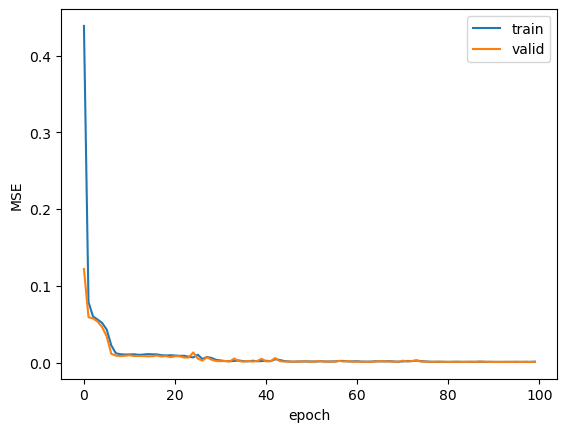

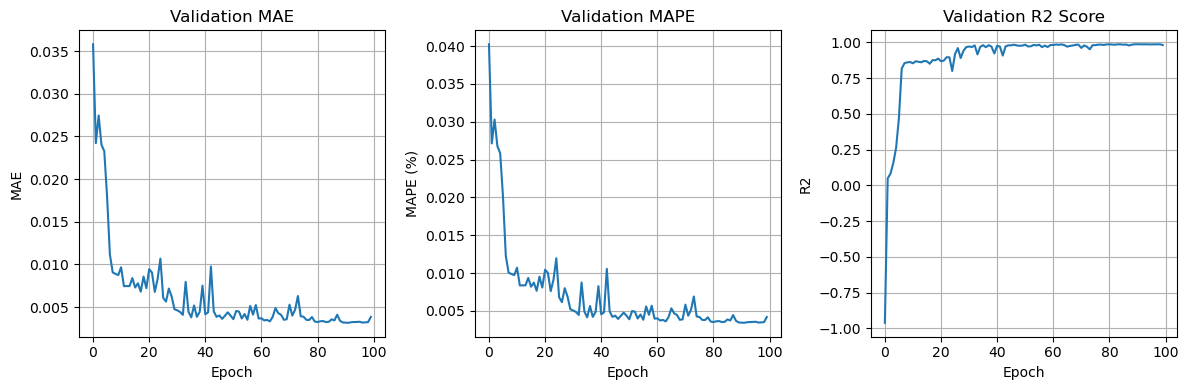

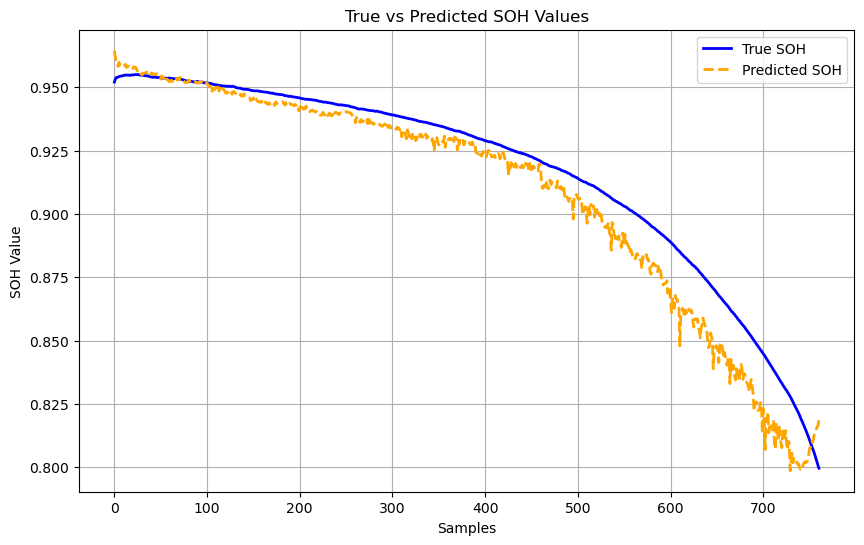

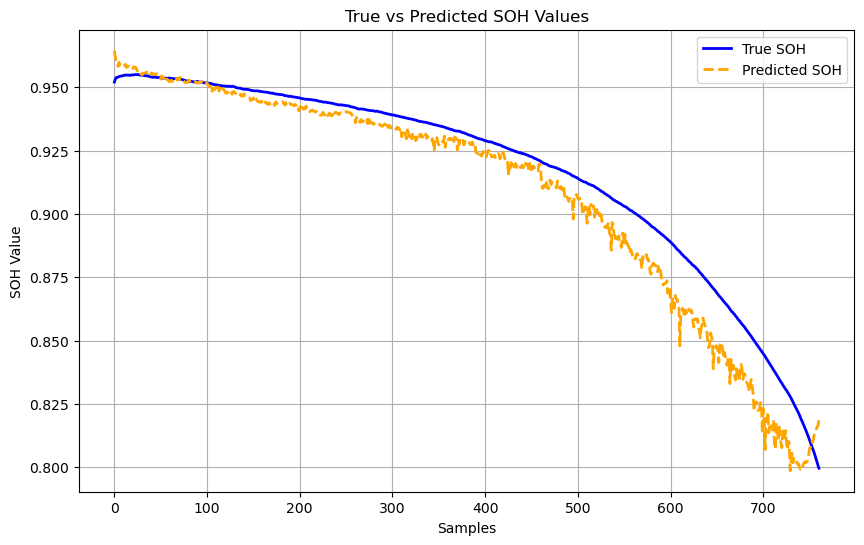

In [16]:
import argparse
import torch
from copy import deepcopy
import sys
import traceback

def get_args():
    parser = argparse.ArgumentParser(description='A benchmark for SOH estimation')
    parser.add_argument('--random_seed', type=int, default=2023)
    # data
    parser.add_argument('--data', type=str, default='MIT',choices=['XJTU','MIT'])
    parser.add_argument('--input_type',type=str,default='charge',choices=['charge','partial_charge','handcraft_features'])
    parser.add_argument('--test_battery_id',type=int,default=1,help='test battery id, 1-8 for XJTU (1-15 for batch-2), 1-5 for MIT')
    parser.add_argument('--batch_size',type=int,default=128)
    parser.add_argument('--normalized_type',type=str,default='minmax',choices=['minmax','standard'])
    parser.add_argument('--minmax_range',type=tuple,default=(-1,1),choices=[(0,1),(-1,1)])
    parser.add_argument('--batch', type=int, default=9,choices=[1,2,3,4,5,6,7,8,9])

    # model
    parser.add_argument('--model',type=str,default='GRUModel',choices=['GRUModel', 'TransCNN','CNN','LSTM','GRU','MLP','Attention'])
    # CNN lr=2e-3  early_stop=30

    parser.add_argument('--lr',type=float,default=2e-3)
    parser.add_argument('--weight_decay', default=5e-4)
    parser.add_argument('--n_epoch',type=int,default=100)
    parser.add_argument('--early_stop',default=30)
    parser.add_argument('--device',default='cpu')
    parser.add_argument('--save_folder',default='results')
    parser.add_argument('--experiment_num',default=1,type=int,help='The number of times you want to repeat the same experiment')
    parser.add_argument('--test_ids', type=int, nargs='+', default=[1], help='List of test battery IDs to evaluate')
    parser.add_argument('--input_size', type=int, default=4)     # 输入通道
    parser.add_argument('--hidden_size', type=int, default=64)   # 隐藏层
    parser.add_argument('--output_size', type=int, default=1)    # 输出 SOH 回归

    # Use parse_known_args to ignore unrecognized arguments
    args, unknown = parser.parse_known_args()
    return args

def load_data(args, test_battery_id):
    loader = XJTUDdataset(args) if args.data == 'XJTU' else MITDdataset(args)
    if args.input_type == 'charge':
        return loader.get_charge_data(test_battery_id)
    elif args.input_type == 'partial_charge':
        return loader.get_partial_data(test_battery_id)
    else:
        return loader.get_features(test_battery_id)

def run_experiment(args, save_prefix):
    try:
        data_loader = load_data(args, test_battery_id=args.test_battery_id)
        model = SOHMode(args)
        model.Train(data_loader['train'], data_loader['valid'], data_loader['test'],
                    save_folder=save_prefix)
        del model, data_loader
        torch.cuda.empty_cache()
    except Exception as ex:
        print(f"[Error] Batch {args.batch}, TestBattery {args.test_battery_id}, Model {args.model}, Input {args.input_type}: {ex}")
        traceback.print_exc()
        torch.cuda.empty_cache()

    
    
def main(args, batches=None, test_ids=None):
    batches = batches or [args.batch]
    test_ids = test_ids or [args.test_battery_id]

    for batch in batches:
        for test_id in test_ids:
            args.batch = batch
            args.test_battery_id = test_id
            for e in range(args.experiment_num):
                print(f"\nRunning: {args.model}, Batch={batch}, TestID={test_id}, Exp={e + 1}")
                save_path = f'results/{args.data}-{args.input_type}/{args.model}/batch{batch}-testbattery{test_id}/experiment{e + 1}'
                run_experiment(args, save_path)


def multi_task_XJTU():  # 一次性训练所有模型和所有输入类型
    args = get_args()
    setattr(args,'data','XJTU')
    for m in ['GRUModel', 'TransCNN','CNN','MLP','Attention','LSTM','GRU']:
        for type in ['handcraft_features','charge','partial_charge']:
            setattr(args, 'model', m)
            setattr(args, 'input_type',type)
            main(args)
            torch.cuda.empty_cache()

def multi_task_MIT():
    args = get_args()
    for norm in ['standard', 'minmax']:
        args.normalized_type = norm
        args.minmax_range = (0, 1)
        args.data = 'MIT'
        for m in ['GRU']:
            for input_type in ['partial_charge']:
                args.model = m
                args.input_type = input_type
                for batch in range(1, 10):
                    args.batch = batch
                    for test_id in [1, 2, 3, 4, 5]:
                        args.test_battery_id = test_id
                        for e in range(5):
                            print(f"\n[MIT Run] Model={args.model}, Batch={batch}, TestID={test_id}, Input={input_type}, Norm={norm}, Exp={e + 1}")
                            save_path = f'results/{norm}/{args.data}-{args.input_type}/{args.model}/batch{batch}-testbattery{test_id}/experiment{e + 1}'
                            run_experiment(args, save_path)


def crossval_mit(
    models=['GRUModel'], 
    input_types=['charge', 'partial_charge', 'handcraft_features'],
    normalization_types=['minmax', 'standard'],
    test_ids=[1, 2, 3, 4, 5],
    batches=range(1, 10),
    experiment_num=1
):
    args = get_args()
    args.data = 'MIT'
    args.experiment_num = experiment_num

    for norm in normalization_types:
        args.normalized_type = norm
        args.minmax_range = (-1, 1) if norm == 'minmax' else (0, 1)

        for batch in batches:
            for test_id in test_ids:
                for model_name in models:
                    for input_type in input_types:
                        for e in range(experiment_num):
                            args_copy = deepcopy(args)
                            args_copy.batch = batch
                            args_copy.test_battery_id = test_id
                            args_copy.model = model_name
                            args_copy.input_type = input_type

                            print(f"\n[CrossVal] Batch={batch}, Fold={test_id}, Model={model_name}, "
                                  f"Input={input_type}, Norm={norm}, Exp={e+1}")
                            
                            save_path = f'results/crossval/{norm}/{args_copy.data}-{input_type}/{model_name}/batch{batch}-fold{test_id}/experiment{e+1}'
                            run_experiment(args_copy, save_path)

                          
                            
if __name__ == '__main__':
    args = get_args()

#     from argparse import ArgumentParse

#     parser = ArgumentParser()
#     parser.add_argument('--task', type=str, default='crossval_mit', choices=[
#         'single', 'multi_xjtu', 'multi_mit', 'crossval_mit'
#     ])
#     task_args, _ = parser.parse_known_args()
    task = 'crossval_mit'

    if task == 'single':
        for e in range(args.experiment_num):
            print(f"\n[Single Run] {args.model} on Battery {args.test_battery_id}, Batch {args.batch}, Input={args.input_type}")
            save_path = f'results/{args.data}-{args.input_type}/{args.model}/batch{args.batch}-testbattery{args.test_battery_id}/experiment{e + 1}'
            run_experiment(args, save_path)

    elif task == 'multi_xjtu':
        multi_task_XJTU()

    elif task == 'multi_mit':
        multi_task_MIT()

    elif task == 'crossval_mit':
        crossval_mit(
        models=['GRUModel'],
        input_types=['charge'],
        normalization_types=['minmax'],
        test_ids=[1],
        batches=[1],
        experiment_num=1
        )